# 안녕하세요^^ 
# AIVLE 미니 프로젝트3차 팀 미션입니다. 
# 주어진 문제를 잘 읽고 해결하시길 바랍니다.


## 올레TV 예능 콘텐츠 중 하나인 프로그램 "코미디빅리그"의 영상을 분석하고 코너를 분류하는 AI 모델을 만들어 보세요.

"코미디빅리그" 는 tvN에서 방영 중인 서바이벌 형식의 공개 코미디 프로그램으로 3개월 단위로 인기 코너를 선정하는 방식인 쿼제를 도입하고 있다. 
이번 과제는 2022년 1쿼터(1~3월) 방영분 중 2월 방영한 3편을 학습 데이터로 하여 3월 방송의 코너 구간을 추출해내는 것입니다.

아래의 조건들을 참고하여 문제를 해결하세요.
> - 주어진 데이터 ( Train 데이터 :  2월 방영분 3편 / Test 데이터 : 3월 방영분 1편 )
> - 제출 파일은 <font color="red">.ipynb 파일</font>과  조에서 각 과정마다 문제 해결을 위해 진행한 방법을 정리한 <font color="red">발표자료(.pptx)</font>를 포함히여 제출합니다.<br> 
①데이터 분석 및 학습데이터 생성, ②데이터 전처리, ③AI 모델링(아키텍처, 성능비교), ④분류 결과 <br> 
※ 각 과정은 문제 해결 방법에 따라 변경 가능<br><br>
> <b>제출 파일( 압축파일명 : [팀]미니프로젝트3차_AI 0반_00조.zip) </b> <br>
>> ① 코드 : [팀]미니프로젝트3차_AI 0반_00조.ipynb <br>
>> ② 발표자료 : [팀]미니프로젝트3차_AI 0반 00조.pptx <br>




---

# 0. 환경 설정하기

### 1) 구글 드라이브 연결하기

In [1]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) 경로 설정하기

In [2]:
# ROOT_PATH 확인 
import os

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive/0928_team"
else :
  ROOT_PATH = os.path.abspath('..')

# 비디오 파일이 저장되어 있는 폴더
VIDEO_PATH = ROOT_PATH + "/video"
IMAGE_PATH = ROOT_PATH + "/image"

# 모델 학습을 위한 데이터 
TRAIN_PATH = IMAGE_PATH + "/train"
# 모델 예측을 위한 test 데이터
TEST_PATH = IMAGE_PATH + "/test"

MODEL_PATH = ROOT_PATH + "/model"

### 3) 영상 데이터 다운로드하기

In [ ]:
# test data 다운로드
!pip install gdown

import gdown
import shutil

google_path = 'https://drive.google.com/uc?id='
file_id = '1p4up6pPd0NqUIaf6mlc2mq12r6NYGDOI'
output_name = 'video.zip'

gdown.download(google_path+file_id,output_name,quiet=False)

shutil.move("./" + output_name, ROOT_PATH)

import zipfile

with zipfile.ZipFile(ROOT_PATH + "/video.zip") as z:
    z.extractall(ROOT_PATH)


# 미니프로젝트 3차 팀 미션 지금부터 시작하세요!

##필요한 모듈 임포트하기

In [7]:
import shutil
import os
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
from PIL import Image

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.backend import clear_session
from keras.layers import Dense, Dropout, Activation, Embedding, Input, ZeroPadding2D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Add,MaxPool2D,Activation,Concatenate,AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam


import os.path
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from tensorflow.keras.utils import to_categorical

import random as rd

## train 데이터 기초 전처리
- 1초 단위로 '220206.mp4', '220220.mp4' 파일을 이미지화 한다.

In [ ]:
TIME_MEASUREMENT_UNIT = 1
VIDEO_PATH = ROOT_PATH + "/video"
IMAGE_PATH = ROOT_PATH + "/image"

if not os.path.exists(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)

name = ('220206','220220')
for n in name:
    video = cv2.VideoCapture(VIDEO_PATH + "/train/" + n + '.mp4')
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            frame_sec = video.get(cv2.CAP_PROP_POS_MSEC)/1000
            if frame_sec.is_integer():
                if (frame_sec % TIME_MEASUREMENT_UNIT == 0):
                    filename = IMAGE_PATH + '/train_new/' + n +'_' + f"{str(round(frame_sec)):0>4}" + '.jpg' # 0000 형식...
                    cv2.imwrite(filename, frame)
        else:
            break

video.release()

###이미지 데이터 클래스 별 라벨링.
- 사이코러스 : chorus
- 코빅엔터 : enter
- 결혼해두목 : boss
- 두분사망토론 : discussion
- 코너와 관련 없는 부분 : opening_ending

In [ ]:
# 220206 : ~115(no), 116~965 (enter) 966(no_corner) 967~1599 (chorus) 1601~2332(discussion) ~3026(boss) 3027~ (no)
# 220220 : ~114(no) 115~837(chorus) 839~1584(boss) ~2469 (enter) ~3253(diss) ~3353(no)

FROM_PATH = IMAGE_PATH + '/train_new/'
TO_PATH = IMAGE_PATH + '/train_new/opening_ending/'

for i in range(0,1):
    shutil.move(FROM_PATH+'220206_'+ f"{str(i):0>4}"  + '.jpg' , TO_PATH)

## 전략 별 추가적인 데이터 전처리.
- 전략 B : 좌측 상단의 코너명만 크롭하기 (김기원, 정연수)
- 전략 C : 주요 이미지만 사용하여 모델링하기 -> ( 김환웅, 윤별)
- 전략 D : imagedatagenerator 내에서 이미지 자체 조정 (최현우, 이서연)



### 전략B :  좌측 상단의 코너명만 크롭하기 (김기원, 정연수)
- 좌측 상단 부분만 크롭하여 따로 데이터셋을 생성한다.

train 이미지 크롭

In [ ]:
PLANB_PATH = IMAGE_PATH + "/b_train"

In [ ]:
labels = os.listdir(TRAIN_PATH)

# 이미지 크롭 함수
def crop_images():
  for l in labels:
    path = TRAIN_PATH + '/' + l
    for i in range(len(os.listdir(path))):
      img = Image.open(path + '/' + str(i) + '.jpg')
      crop_img = img.crop((50,60,148,73))
      crop_img.save(PLANB_PATH + '/' + l + '/' + str(i) + '.jpg')

# 각 라벨별 폴더 생성
for l in labels:
    os.mkdir(PLANB_PATH + '/' + l)

# 크롭 진행
crop_images()

train 이미지 모델 학습

In [ ]:
batch_size = 16
img_height = 26
img_width = 196

b_train_datagen = ImageDataGenerator(
  rescale = 1./ 255,
  validation_split=0.2
)

b_train_generator = b_train_datagen.flow_from_directory(
    PLANB_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='training',
    class_mode='categorical',
    shuffle=True
)

b_validation_generator = b_train_datagen.flow_from_directory(
    PLANB_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

Found 5012 images belonging to 5 classes.
Found 1250 images belonging to 5 classes.


In [ ]:
b_train_generator.class_indices

{'boss': 0, 'chorus': 1, 'discussion': 2, 'enter': 3, 'opening_ending': 4}

Epoch 1/50
314/314 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9864
Epoch 1: val_loss improved from inf to 0.04504, saving model to /content/drive/MyDrive/0928_team/model/best_weight.h5
314/314 [==============================] - 92s 289ms/step - loss: 0.0460 - accuracy: 0.9864 - val_loss: 0.0450 - val_accuracy: 0.9968
Epoch 2/50
314/314 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9982
Epoch 2: val_loss improved from 0.04504 to 0.01505, saving model to /content/drive/MyDrive/0928_team/model/best_weight.h5
314/314 [==============================] - 87s 278ms/step - loss: 0.0141 - accuracy: 0.9982 - val_loss: 0.0150 - val_accuracy: 0.9968
Epoch 3/50
314/314 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9978
Epoch 3: val_loss did not improve from 0.01505
314/314 [==============================] - 87s 277ms/step - loss: 0.0163 - accuracy: 0.9978 - val_loss: 0.0658 - val_accuracy: 0.9968
Epoch 4/50
314/314 [===

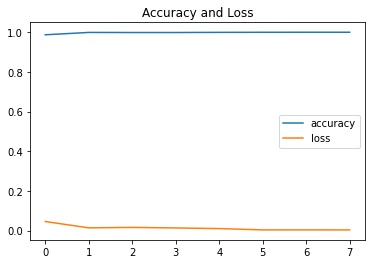

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_height, img_width, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_height, img_width, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

weight_path = MODEL_PATH + '/best_weight.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping( monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)

history = model.fit(b_train_generator, validation_data= b_validation_generator, epochs=50, verbose=1, callbacks=[checkpoint, early_stopping])

model.load_weights(weight_path)
model.save(MODEL_PATH + '/미니프로젝트3차_03조_B.h5')

# 모델 성능 확인
pd.DataFrame(history.history)[['accuracy', 'loss']].plot()
plt.title("Accuracy and Loss")
plt.show()

test 데이터 크롭

In [ ]:
PLANB_TEST_PATH = IMAGE_PATH + "/b_test"
# 크롭
for i in range(len(os.listdir(TEST_PATH))):
    img = Image.open(TEST_PATH + '/' + str(i) + '.jpg')
    crop_img = img.crop((50,60,148,73))
    crop_img.save(PLANB_TEST_PATH + '/' + str(i) + '.jpg')

test 데이터 예측

In [ ]:
# 테스트 해보기
batch_size = 16
img_height = 26
img_width = 196

test_datagen = ImageDataGenerator(
  rescale = 1./ 255,
)

test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH+'/b_test',
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    shuffle=False
)

Found 3182 images belonging to 1 classes.


In [ ]:
def my_model_predict(test_generator, MODEL_PATH):
    import pandas as pd
    import tensorflow as tf
    from tensorflow import keras
    import re

    # 학습된 모델 불러오기
    loaded_model = tf.keras.models.load_model(MODEL_PATH + '/미니프로젝트3차_03조_B.h5')

    # 불러온 모델로 예측하기
    pred = loaded_model.predict(test_generator,verbose=1)
    y_pred = pred.argmax(axis=1)

    # 예측 결과를 저장한 데이터 프레임 생성하기
    second = []
    filename = test_generator.filenames
    for f in filename:
        second.append(int(re.sub(r'[^0-9]', '', f)))
    predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
    predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                    1 : 'chrous',
                                                    2 : 'discussion',
                                                    3 : 'enter',
                                                    4 : 'opening_ending'})
    predict_df = predict_df.sort_values('time', ignore_index=True)

    return predict_df

In [ ]:
predict_df = my_model_predict(test_generator, MODEL_PATH)

199/199 [==============================] - 5s 24ms/step


In [ ]:
predict_df.head()

,time,class
0,0,opening_ending
1,1,opening_ending
2,2,opening_ending
3,3,opening_ending
4,4,opening_ending


In [ ]:
planb_predict = predict_df # 비교를 위해 저장

### 전략 C : 주요 이미지만 사용하여 모델링하기 (김환웅, 윤별)
- 먼저 이미지를 취사선택하여 기본 학습을 진행한다.
- resnet을 사용.

In [ ]:
PLANC_PATH = IMAGE_PATH + "/c_train"

In [ ]:
c_train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2,
)

batch_size= 32
img_height= 256
img_sidth = 256

# train_genrator 생성
c_train_generator = c_train_datagen.flow_from_directory(
    PLANC_PATH,
    batch_size = batch_size,
    target_size=(img_height, img_sidth),
    class_mode = 'categorical',
    subset = 'training',
    shuffle=True
)

# validation_generator 생성
c_validation_generator = c_train_datagen.flow_from_directory(
    PLANC_PATH, 
    batch_size= batch_size,
    target_size=(img_height, img_sidth),
    class_mode = 'categorical',
    subset = 'validation',
    shuffle=False
)

Found 3906 images belonging to 5 classes.
Found 974 images belonging to 5 classes.


#### 첫번째 모델

In [ ]:
clear_session()

def resnetConv2D(x, filters=64, strides = (1,1), filters_scale = 1) :
    filters = filters*filters_scale

    x = Conv2D(filters,(1,1),strides=strides,padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(4*filters, (1, 1), strides=(1, 1), padding='valid')(x)

    return x

def resnetConv1(x) :
    x = ZeroPadding2D(padding=(3,3))(x)
    x = Conv2D(64,(7,7),strides=(2,2),padding = 'valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

def resnetConv2(x) :
    x = MaxPooling2D((3,3), 2)(x)

    sc = x ## shortcut

    for i in range(0,3) :
        if i == 0 :
            x = resnetConv2D(x, strides = (1,1),filters_scale = 1)
            
            sc = Conv2D(256, kernel_size = (1, 1), strides=(1, 1), padding='valid')(sc)            
            x = BatchNormalization()(x)
            sc = BatchNormalization()(sc)
            
            x = Add()([x, sc])
            x = Activation('relu')(x)

            sc = x

        else : 
            x = resnetConv2D(x,strides = (1,1), filters_scale = 1)
            x = BatchNormalization()(x)

            x = Add()([x, sc])
            x = Activation('relu')(x)

            sc = x

    return x

def resnetConv3(x) :
    sc = x

    for i in range(0,4) : 
        if i == 0 :
            x = resnetConv2D(x,strides=(2,2),filters_scale=2)
            sc = Conv2D(512,kernel_size =(1,1),strides=(2,2),padding='valid')(sc)
            x=BatchNormalization()(x)
            sc = BatchNormalization()(sc)
            x = Add()([x,sc])
            x = Activation('relu')(x)
            sc = x
        
        else :
            x = resnetConv2D(x,strides = (1,1), filters_scale=2)
            x = BatchNormalization()(x)

            x = Add()([x,sc])
            x = Activation('relu')(x)

            sc = x

    return x

def resnetConv4(x) :
    sc = x

    for i in range(0, 6) :
        if i == 0 :
            x = resnetConv2D(x, strides = (2,2), filters_scale = 4)

            sc = Conv2D(filters = 1024, kernel_size = (1,1), strides = (2,2), padding = 'valid')(sc)
            x = BatchNormalization()(x)
            sc = BatchNormalization()(sc)
            x = Add()([x, sc])
            Activation('relu')(x)
            sc = x


        else :
            x = resnetConv2D(x, strides = (1,1), filters_scale=4)
            x = BatchNormalization()(x)

            x = Add()([x,sc])
            x = Activation('relu')(x)

            sc = x

    return x

def resnetConv5(x) :
    sc = x

    for i in range(0, 3) :
        if i == 0 :
            x = resnetConv2D(x,strides = (2,2),filters_scale = 8)

            sc = Conv2D(filters = 2048, kernel_size = (1,1), strides = (2,2),padding = 'valid')(sc)
            x = BatchNormalization()(x)
            sc = BatchNormalization()(sc)

            x = Add()([x,sc])
            x = Activation('relu')(x)
            sc = x
        else :
            x = resnetConv2D(x, strides = (1,1),filters_scale = 8)
            x = BatchNormalization()(x)

            x = Add()([x, sc])
            x = Activation('relu')(x)

            sc = x

    return x

def myModel() :
    _input = Input(shape = (256,256,3), dtype = 'float32', name='input')
    x = resnetConv1(_input)
    x = resnetConv2(x)
    x = resnetConv3(x)
    x = resnetConv4(x)
    x = resnetConv5(x)
    x = GlobalAveragePooling2D()(x)
    
    feature_vector = Dense(256, activation = 'relu',name = 'feature_vector')(x) ## feature vector

    output = Dense(5, activation='softmax')(feature_vector)## age

    my_resnet_model = Model(_input,output)

    return my_resnet_model


In [ ]:
model = myModel() # resnet을 통한 모델 생성.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filename = MODEL_PATH+'/'+'미니프로젝트3차_03조_C1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=True )
es = EarlyStopping(monitor='val_loss',  patience=5,  verbose=1, restore_best_weights=True)

In [ ]:
history = model.fit_generator(c_train_generator, epochs=50, validation_data=c_validation_generator, callbacks=[checkpoint, es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.8154
Epoch 1: val_loss improved from inf to 4.61803, saving model to /content/drive/MyDrive/0928_team/model/미니프로젝트3차_03조_C1.h5
123/123 [==============================] - 1026s 8s/step - loss: 0.6660 - accuracy: 0.8154 - val_loss: 4.6180 - val_accuracy: 0.2608
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9419
Epoch 2: val_loss did not improve from 4.61803
123/123 [==============================] - 60s 490ms/step - loss: 0.1845 - accuracy: 0.9419 - val_loss: 40.2284 - val_accuracy: 0.1745
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9411
Epoch 3: val_loss improved from 4.61803 to 1.21380, saving model to /content/drive/MyDrive/0928_team/model/미니프로젝트3차_03조_C1.h5
123/123 [==============================] - 64s 518ms/step - loss: 0.2056 - accuracy: 0.9411 - val_loss: 1.2138 - val_accuracy: 0.7238
Epoch 4/50
123/

평가하기

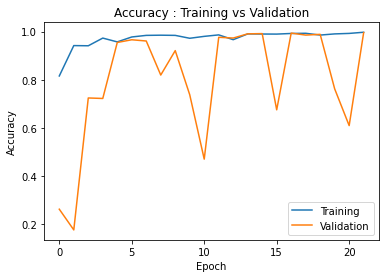

In [ ]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

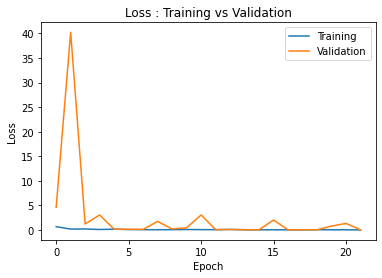

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

In [ ]:
print('--Evaluate--')
scores = model.evaluate_generator(c_validation_generator)
print('%s : %.2f%%' %(model.metrics_names[1], scores[1]*100))

--Evaluate--


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


accuracy : 99.38%


test 데이터

In [ ]:
# 테스트 해보기
batch_size= 32
img_height= 256
img_width = 256

test_datagen = ImageDataGenerator(
  rescale = 1./ 255,
)

test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH+'/test',
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    shuffle=False
)

Found 3182 images belonging to 1 classes.


In [ ]:
pred = model.predict(test_generator,verbose=1)
y_pred = pred.argmax(axis=1)

100/100 [==============================] - 61s 305ms/step


In [ ]:
# 예측 결과를 저장한 데이터 프레임 생성하기
import re
second = []
filename = test_generator.filenames
for f in filename:
    second.append(int(re.sub(r'[^0-9]', '', f[14:])))
predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                1 : 'chrous',
                                                2 : 'discussion',
                                                3 : 'enter',
                                                4 : 'opening_ending'})
predict_df = predict_df.sort_values('time', ignore_index=True)

In [ ]:
predict_df.head()

,time,class
0,0,opening_ending
1,1,opening_ending
2,2,opening_ending
3,3,opening_ending
4,4,opening_ending


In [ ]:
planc_predict1 = predict_df

####두번째 모델

In [ ]:
clear_session()

model2 = Sequential()

model2.add(Input(shape=(256,256,3)))
model2.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 strides = (1,1),
                 padding='same',
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 strides = (1,1),
                 padding='same',
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(MaxPool2D(pool_size=(2,2), 
                    strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(filters=128, 
                 kernel_size=(3,3), 
                 strides = (1,1),
                 padding='same',
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=128, 
                 kernel_size=(3,3), 
                 strides = (1,1),
                 padding='same',
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(MaxPool2D(pool_size=(2,2), 
                    strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(5, activation='softmax'))

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filename = MODEL_PATH+'/'+'미니프로젝트3차_03조_C2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=True )
es = EarlyStopping(monitor='val_loss',  patience=5,  verbose=1, restore_best_weights=True)

In [ ]:
history2 = model2.fit_generator(c_train_generator, epochs=25, validation_data=c_validation_generator, callbacks=[checkpoint, es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
123/123 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.8827
Epoch 1: val_loss improved from inf to 2.46231, saving model to /content/drive/MyDrive/0928_team/model/미니프로젝트3차_03조_C2.h5
123/123 [==============================] - 68s 508ms/step - loss: 0.3600 - accuracy: 0.8827 - val_loss: 2.4623 - val_accuracy: 0.2474
Epoch 2/25
123/123 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9885
Epoch 2: val_loss did not improve from 2.46231
123/123 [==============================] - 55s 445ms/step - loss: 0.0541 - accuracy: 0.9885 - val_loss: 9.9561 - val_accuracy: 0.3552
Epoch 3/25
123/123 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9972
Epoch 3: val_loss did not improve from 2.46231
123/123 [==============================] - 55s 445ms/step - loss: 0.0184 - accuracy: 0.9972 - val_loss: 4.8935 - val_accuracy: 0.1027
Epoch 4/25
123/123 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.998

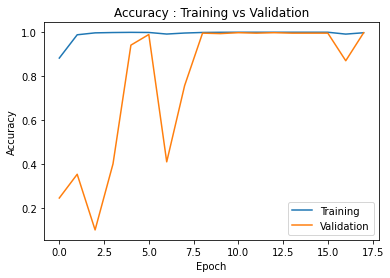

In [ ]:
if not isinstance(history2, dict):
  history2 = history2.history

plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

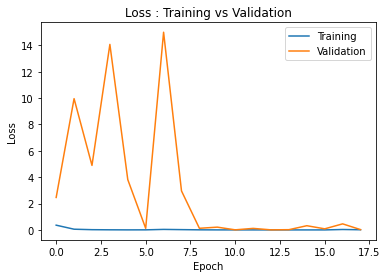

In [ ]:
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

In [ ]:
print('--Evaluate--')
scores = model2.evaluate_generator(c_validation_generator)
print('%s : %.2f%%' %(model2.metrics_names[1], scores[1]*100))

--Evaluate--


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


accuracy : 99.79%


In [ ]:
pred = model2.predict(test_generator,verbose=1)
y_pred = pred.argmax(axis=1)

100/100 [==============================] - 29s 288ms/step


In [ ]:
# 예측 결과를 저장한 데이터 프레임 생성하기
import re
second = []
filename = test_generator.filenames
for f in filename:
    second.append(int(re.sub(r'[^0-9]', '', f[14:])))
predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                1 : 'chrous',
                                                2 : 'discussion',
                                                3 : 'enter',
                                                4 : 'opening_ending'})
predict_df = predict_df.sort_values('time', ignore_index=True)

In [ ]:
planc_predict2 = predict_df

### 전략 D : imagedatagenerator 내에서 이미지 자체 조정 (최현우, 이서연)
- 어떤 파라미터를 조절해야 잘 나올지 생각해보기, 전이학습 수행. lessnet

#### 최현우님

In [26]:
dir = Path(ROOT_PATH + '/image/train')
filepath = list(dir.glob(r'**/*.jpg'))
def proc_img(filepath):
    # 이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepath)
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 6469

Number of different labels: 5

Labels: ['boss' 'enter' 'chorus' 'discussion' 'opening_ending']


In [27]:
train_df,test_df = train_test_split(df,random_state=2022, test_size=0.2)
train_df.shape,test_df.shape

((5175, 2), (1294, 2))

In [28]:
img_height = 120 #480
img_width = 217 #854

In [ ]:
d_train_datagen = ImageDataGenerator(rescale = 1. /255,
                                   validation_split=0.2)

d_train_generator = d_train_datagen.flow_from_directory(ROOT_PATH + '/image/train',
                                                 target_size = (img_height, img_width),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training',
                                                 shuffle = True)

d_val_genertor  = d_train_datagen.flow_from_directory(ROOT_PATH + '/image/train',
                                                 target_size = (img_height, img_width),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation',
                                                 shuffle = False)

Found 5177 images belonging to 5 classes.
Found 1292 images belonging to 5 classes.


In [ ]:
keras.backend.clear_session()
model = keras.models.Sequential()

model.add(keras.layers.Input(shape = (img_height,img_width,3 )))
model.add(keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(keras.layers.Dropout(rate = 0.25))

# pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation = 'swish'))
model.add(keras.layers.Dense(32, activation = 'swish'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate = 0.25))

model.add(keras.layers.Dense(5, activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 217, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 120, 217, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 108, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 108, 32)       0         
                                                                 
 flatten (Flatten)           (None, 207360)            0         
                                                                 
 dense (Dense)               (None, 32)                6

In [ ]:
MODEL_PATH = ROOT_PATH + '/model'

In [ ]:
es = EarlyStopping(
    verbose = 1,
    patience = 5,
    restore_best_weights = True
)
checkpoint = ModelCheckpoint(
    filepath = MODEL_PATH + '/best_model2.h5' , 
    save_best_only = True,
    save_weights_only = True
)

In [ ]:
history = model.fit(d_train_generator, validation_data = d_val_genertor, verbose = 1, epochs = 30, callbacks = [es, checkpoint])

Epoch 1/30
162/162 [==============================] - 820s 5s/step - loss: 0.7445 - accuracy: 0.7491 - val_loss: 2.4391 - val_accuracy: 0.1981
Epoch 2/30
162/162 [==============================] - 195s 1s/step - loss: 0.2011 - accuracy: 0.9720 - val_loss: 3.7421 - val_accuracy: 0.0658
Epoch 3/30
162/162 [==============================] - 193s 1s/step - loss: 0.0464 - accuracy: 0.9981 - val_loss: 1.7139 - val_accuracy: 0.2632
Epoch 4/30
162/162 [==============================] - 193s 1s/step - loss: 0.0235 - accuracy: 0.9986 - val_loss: 0.2148 - val_accuracy: 0.9791
Epoch 5/30
162/162 [==============================] - 195s 1s/step - loss: 0.0150 - accuracy: 0.9996 - val_loss: 0.0282 - val_accuracy: 0.9969
Epoch 6/30
162/162 [==============================] - 193s 1s/step - loss: 0.0095 - accuracy: 0.9998 - val_loss: 0.0160 - val_accuracy: 0.9969
Epoch 7/30
162/162 [==============================] - 190s 1s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9961

In [ ]:
model.load_weights(MODEL_PATH+'/best_model2.h5')
model.save(MODEL_PATH + '/미니프로젝트3차_03조_D1.h5')

In [ ]:
# 테스트 해보기
batch_size= 32
img_height= 120
img_width = 217

test_datagen = ImageDataGenerator(
  rescale = 1./ 255,
)

test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH+'/test',
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    shuffle=False
)

Found 3182 images belonging to 1 classes.


In [ ]:
pred = model.predict(test_generator,verbose=1)
y_pred = pred.argmax(axis=1)

100/100 [==============================] - 127s 493ms/step


In [ ]:
# 예측 결과를 저장한 데이터 프레임 생성하기
import re
second = []
filename = test_generator.filenames
for f in filename:
    second.append(int(re.sub(r'[^0-9]', '', f[14:])))
predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                1 : 'chrous',
                                                2 : 'discussion',
                                                3 : 'enter',
                                                4 : 'opening_ending'})
predict_df = predict_df.sort_values('time', ignore_index=True)

In [ ]:
pland_predict1 = predict_df

전이학습 모델

In [29]:
# 파라미터 조정 전처리

def create_gen():
    img_height = 120 #480
    img_width = 217 #854
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(img_height, img_width), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(img_height, img_width),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(img_height, img_width),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# 모델들의 전이학습
# 전이학습 모델 전부 다 가져와서 학습

models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
}
# 제네레이터 생성
train_generator,test_generator,train_images,val_images,test_images=create_gen()

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(img_height, img_width, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    # pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(16, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(16, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=5,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

In [30]:
# 테스트 해보기
batch_size= 32
img_height= 120
img_width = 217

test_datagen = ImageDataGenerator(
  rescale = 1./ 255,
)

test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH+'/test',
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    shuffle=False
)

Found 3182 images belonging to 1 classes.


In [34]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(img_height, img_width, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    # pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(16, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(16, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
es = EarlyStopping(
    verbose = 1,
    patience = 5,
    restore_best_weights = True
)
checkpoint = ModelCheckpoint(
    filepath = MODEL_PATH + '/best_model.h5' , 
    save_best_only = True,
    save_weights_only = True
)

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=10, callbacks = [es, checkpoint], verbose = 1)

In [ ]:
#model = get_model(tf.keras.applications.ResNet50V2)
pred = model.predict(test_generator,verbose=1)
y_pred = pred.argmax(axis=1)

100/100 [==============================] - 282s 3s/step


In [ ]:
# 예측 결과를 저장한 데이터 프레임 생성하기
import re
second = []
filename = test_generator.filenames
for f in filename:
    second.append(int(re.sub(r'[^0-9]', '', f[14:])))
predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                1 : 'chrous',
                                                2 : 'discussion',
                                                3 : 'enter',
                                                4 : 'opening_ending'})
predict_df = predict_df.sort_values('time', ignore_index=True)

In [ ]:
predict_df

,time,class
0,0,discussion
1,1,enter
2,2,discussion
3,3,discussion
4,4,enter
...,...,...
3177,3177,enter
3178,3178,boss
3179,3179,boss
3180,3180,boss


In [ ]:
pland_predict1 = predict_df

#### 이서연님

In [5]:
(img_height,img_width) = 120, 215

train_datagen = ImageDataGenerator(
    rescale=1. /255,
    validation_split=0.2,
    rotation_range=30, # 회전제한 각도 30도
    zoom_range=0.15, # 확대 축소 15%
    width_shift_range=0.2, # 좌우이동 20%
    height_shift_range=0.2, # 상하이동 20%
    shear_range=0.15, # 반시계방향의 각도
    horizontal_flip=True  # 좌우 반전 True
)

# train_genrator 생성
train_generator = train_datagen.flow_from_directory(
    ROOT_PATH + '/image/train',
    batch_size=16,
    target_size=(img_height,img_width), #img height, width
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# validation_generator 생성
validation_generator = train_datagen.flow_from_directory(
    ROOT_PATH + '/image/train',
    batch_size=16,
    target_size=(img_height,img_width), #img height, width
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5177 images belonging to 5 classes.
Found 1292 images belonging to 5 classes.


In [6]:
# 1. 세션 클리어
keras.backend.clear_session()
# 2. 모델 선언
base = MobileNetV2(input_shape=(img_height,img_width,3),include_top=False,weights='imagenet')
base.trainable = True
model = Sequential() 
# 3. 레이어 추가
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
# 4. 컴파일
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])
# 요약
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                           

In [8]:
# 모델 개선이 이뤄지지 않을 경우 학습률을 재설정하여 모델의 개선을 유도하는 콜백 함수
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1) 
# ModelCheckpoint 
checkpoint = ModelCheckpoint(ROOT_PATH+"/best_weight3.h5", save_best_only=True, save_weights_only=True)

# early_stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=0,
                               restore_best_weights=True)

In [10]:
# 모델 학습
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[checkpoint, early_stopping,reduce_lr],verbose=1)

Epoch 1/30
324/324 [==============================] - 918s 3s/step - loss: 0.8531 - accuracy: 0.7133 - val_loss: 7.0808 - val_accuracy: 0.2794 - lr: 0.0010
Epoch 2/30
324/324 [==============================] - 319s 986ms/step - loss: 0.6514 - accuracy: 0.7896 - val_loss: 2.6928 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 3/30
324/324 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.8323
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
324/324 [==============================] - 318s 981ms/step - loss: 0.5235 - accuracy: 0.8323 - val_loss: 10.9801 - val_accuracy: 0.1563 - lr: 0.0010
Epoch 4/30
324/324 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8760
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
324/324 [==============================] - 315s 971ms/step - loss: 0.3710 - accuracy: 0.8760 - val_loss: 7.0399 - val_accuracy: 0.2810 - lr: 1.0000e-04
Epoch 5/30
324/324 [==================

In [11]:
# 모델 저장
model.load_weights(ROOT_PATH+'/best_weight3.h5')
model.save(MODEL_PATH+'/미니프로젝트3차_03조_D2_2.h5')

In [ ]:
from keras.saving.save import load_model
model = load_model(MODEL_PATH+'/미니프로젝트3차_03조_D2_2.h5')

In [12]:
def my_preprocessing(TEST_PATH):
  test_datagen=ImageDataGenerator(
      rescale=1. /255,
  )
  test_generator=test_datagen.flow_from_directory(
      TEST_PATH,
      batch_size=16,
      target_size=(img_height,img_width), #img height, width
      class_mode='categorical'
  )
  return test_generator

In [13]:
test_generator = my_preprocessing(TEST_PATH)

Found 3182 images belonging to 1 classes.


In [14]:
y_pred = model.predict(test_generator,verbose=1)

199/199 [==============================] - 86s 432ms/step


In [15]:
y_pred = y_pred.argmax(axis=1)

In [16]:
# 예측 결과를 저장한 데이터 프레임 생성하기
import re
second = []
filename = test_generator.filenames
for f in filename:
    second.append(int(re.sub(r'[^0-9]', '', f[14:])))
predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                1 : 'chrous',
                                                2 : 'discussion',
                                                3 : 'enter',
                                                4 : 'opening_ending'})
predict_df = predict_df.sort_values('time', ignore_index=True)

In [17]:
pland_predict2 = predict_df

In [18]:
pland_predict2

,time,class
0,0,opening_ending
1,1,enter
2,2,discussion
3,3,enter
4,4,discussion
...,...,...
3177,3177,opening_ending
3178,3178,boss
3179,3179,boss
3180,3180,chrous


## 최종 비교

### test 데이터 정답 라벨 (채점용)

In [20]:
# test 정답 label
# 0~127, 1039, 1555, 2358, 2951~3181 : opening_ending / 128~1038 : enter / 1040~1554 : chorus / 1556~2357 : boss / 2359~2950 : discussion
# {'boss': 0, 'chorus': 1, 'discussion': 2, 'enter': 3, 'opening_ending': 4}
df_test_label = pd.DataFrame(index=range(3182),columns=['label'])

In [21]:
df_test_label.iloc[0:128] = 'opening_ending'
df_test_label.iloc[1039] = 'opening_ending'
df_test_label.iloc[1555] = 'opening_ending'
df_test_label.iloc[2358] = 'opening_ending'
df_test_label.iloc[2951:3182] = 'opening_ending'

df_test_label.iloc[128:1039] = 'enter'
df_test_label.iloc[1040:1555] = 'chorus'
df_test_label.iloc[1556:2358] = 'boss'
df_test_label.iloc[2359:2951] = 'discussion'

In [ ]:
df_test_label.head()

,label
0,opening_ending
1,opening_ending
2,opening_ending
3,opening_ending
4,opening_ending


In [22]:
# 정확도 비교하기
def compare2df(df_plan,df_test):
    temp = df_plan['class'] == df_test['label']
    print('accuracy : ' ,temp.sum()/len(temp))

In [ ]:
print('-PLAN-B-')
compare2df( planb_predict,df_test_label )

-PLAN-B-
accuracy :  0.7800125707102451


In [ ]:
print('-PLAN-C1-')
compare2df( planc_predict1,df_test_label )

-PLAN-C1-
accuracy :  0.8004399748585795


In [ ]:
print('-PLAN-C2-')
compare2df( planc_predict2,df_test_label )

-PLAN-C2-
accuracy :  0.7787554996857322


In [ ]:
print('-PLAN-D1-1-')
compare2df( pland_predict1,df_test_label )

-PLAN-D1-1-
accuracy :  0.7950974230043998


In [ ]:
print('-PLAN-D1-2-') #전이학습
compare2df( pland_predict1,df_test_label )

-PLAN-D1-2-
accuracy :  0.32338152105593965


In [ ]:
print('-PLAN-D2-') # 서연님.
compare2df( pland_predict2,df_test_label )

-PLAN-D2-
accuracy :  0.1879321181646763


In [23]:
print('-PLAN-D2-') # 서연님2
compare2df( pland_predict2,df_test_label )

-PLAN-D2-
accuracy :  0.19798868636077938
